In [1]:
%load_ext autoreload
%autoreload 2
import yaml
import pandas as pd
from pandarallel import pandarallel
import click
import numpy as np
from tss.manuscript.utils import expand_anno_id
from tss.manuscript.peak_distance import create_anno_tss
import seaborn as sns
import matplotlib.pyplot as plt

thresh=0
numSamp=1
genome="GCF"
with open("manuscript_params.yaml") as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    params=yaml.load(file)
params

params {'PREFIX': 'ncbi_pice_103', 'ROOT_DIR': '/data/isshamie/TSS/', 'DATA_DIR': '/data/isshamie/TSS/NCBI_PICR_103_Processed/', 'DATA_PROCESSED_DIR': '/data/isshamie/TSS/TSS/data/processed/', 'SUPPLEMENTAL_DIR': '/data/isshamie/TSS/Analysis/supplemental/', 'PIPELINE': '/data/isshamie/TSS/tss', 'GENOME_DIR': '/data/isshamie/genome', 'GENOME_FA': '/data/isshamie/genome/picr.fa', 'GENOME_GFF3': '/data/isshamie/genome/updated_final_sort.gff3', 'GENOME_GTF': '/data/isshamie/genome/updated_final_sort.gtf', 'TISSUES': 'BMDM1hKLA,BMDMwt,Brain,FemaleReproductive,Heart,Intestine,', 'META_FILE': '/data/isshamie/TSS/TSS/parameters/raw_metaSamples.tsv'}


/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:19: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


{'OUTDIR': '/data/isshamie/TSS/Analysis/TSS_code/data/processed/manuscript',
 'genome_fasta': '/data/isshamie/genome/ncbi_anno_103/GCF_003668045.1_CriGri-PICR_genomic.fna',
 'annotation': {'synapse': '/data/isshamie/genome/hamster/syn20999279_picr.gff',
  'GCF': '/data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gff'},
 'ncrna_keys': {'synapse': ['lncRNA'],
  'GCF': ['snoRNA', 'snRNA', 'miRNA', 'lnc_RNA']},
 'MERGE_TISSUES': ['all', 'bmdm'],
 'atac_f': '/data/isshamie/TSS/Analysis/Analysis_NCBI_PICR/Results/ATAC_results/CHO/ATAC_ppr.naive_overlap.narrowPeak.sort',
 'all_atac': '/data/isshamie/TSS/Analysis/Analysis_NCBI_PICR/Results/ATAC_results/ATAC_merge.bed',
 'META_SAMPLES': '/data/isshamie/TSS/Analysis/Analysis_03302020/parameters/samples.tsv',
 'peaks_dir': '/data/isshamie/TSS/Analysis/Analysis_NCBI_PICR/f04_peaks/',
 'cpm_thresh': [1, 0],
 'numsamples_thresh': [2, 1]}

### init anno files and parameters

In [2]:
cpu=32
gff_f= "/data/isshamie/genome/hamster/ncbi_anno_103/GCF_003668045.1_CriGri-PICR/GCF_003668045.1_CriGri-PICR_genomic.gff"
reftss_f=f"data/{genome}/genome/refTSS.tsv"
cds_f = f"data/{genome}/genome/CDS.bed"
intron_f = f"data/{genome}/genome/introns.bed"
pc= "mRNA"#.split(',')
ncrna= params['ncrna_keys'][genome] #','.join(params['ncrna_keys'][genome])
ncrna

['snoRNA', 'snRNA', 'miRNA', 'lnc_RNA']

### Peak file names

In [3]:
merge = "data/peaksInfo/samples.merge"
raw_peaks="data/peaksInfo/peaks.merge.tss"
minimal="data/peaksInfo/peaks.merge.tss.minimal"


### Peaks info on samples and the average values. Also uses the thresholds for confident peaks here

In [4]:
peaks_sourceMeta = "data/peaksInfo/peaks.sourceMeta.tsv"
peaks_sourceConfident = "data/peaksInfo/peaks.sourceMeta.confident.index"
expr_thresh = 1 #cpm threshold
num_samples_thresh = 1

### Using the annotation

In [5]:
homeranno= f"data/{genome}/anno/peaks.merge.tss.anno"
peaks_minimal = f"data/{genome}/anno/peaks.merge.tss.minimal.anno"
peaks_homeranno = f"data/{genome}/anno/peaks.merge.tss.minimal.anno"
peaks_distance = f"data/{genome}/anno/peaks.distance.tsv"

### Filter introns and cds names

In [6]:
noncds_peaks = f"data/{genome}/genebody_filters/peaks.nocds.index"
nonintron_peaks = f"data/{genome}/genebody_filters/peaks.nointron.index"
non_cds_intron_peaks = f"data/{genome}/genebody_filters/peaks.nocds.nointron.index"

In [7]:
### revised TSS
pc_tss = f"data/{genome}/refType/pc.index"
ncrna_tss = f"data/{genome}/refType/ncrna.index"
intergenic_tss = f"data/{genome}/refType/ncrna.index"


# filtered tss
allTSS_cds_f = f"data/{genome}/allTSS/thresh{thresh}_numSamp{numSamp}_peaksSankey.rmCDS.csv"
allTSS_f = f"data/{genome}/allTSS/allTSS_thresh{thresh}_numSamp{numSamp}.tsv"


### revised TSS

In [8]:
pc_tss = f"data/{genome}/refType/pc.index"
ncrna_tss = f"data/{genome}/refType/ncrna.index"
intergenic_tss = f"data/{genome}/refType/ncrna.index"

In [9]:
import matplotlib as mpl

In [27]:
pd.read_csv(reftss_f, index_col=0, sep='\t')

,Chr,How,Annotation,Start,End,.1,Strand,.2,ID,actual_start,...,gene,model_evidence,product,transcript_id,Note,exception,inference,end_range,partial,start_range
XR_003479383.1,NW_020822366.1,Gnomon,lnc_RNA,269294,269294,.,+,.,rna-XR_003479383.1,269294,...,LOC113832197,Supporting evidence includes similarity to: 10...,uncharacterized LOC113832197%2C transcript var...,XR_003479383.1,NaN,NaN,NaN,NaN,NaN,NaN
XR_003479384.1,NW_020822366.1,Gnomon,lnc_RNA,551299,551299,.,+,.,rna-XR_003479384.1,551299,...,LOC113832198,Supporting evidence includes similarity to: 10...,uncharacterized LOC113832198,XR_003479384.1,NaN,NaN,NaN,NaN,NaN,NaN
XR_003479386.1,NW_020822366.1,Gnomon,lnc_RNA,696459,696459,.,+,.,rna-XR_003479386.1,696459,...,LOC103159926,Supporting evidence includes similarity to: 10...,uncharacterized LOC103159926%2C transcript var...,XR_003479386.1,NaN,NaN,NaN,NaN,NaN,NaN
XR_003479388.1,NW_020822366.1,Gnomon,lnc_RNA,696459,696459,.,+,.,rna-XR_003479388.1,696459,...,LOC103159926,Supporting evidence includes similarity to: 10...,uncharacterized LOC103159926%2C transcript var...,XR_003479388.1,NaN,NaN,NaN,NaN,NaN,NaN
XR_003479385.1,NW_020822366.1,Gnomon,lnc_RNA,710127,710127,.,+,.,rna-XR_003479385.1,710127,...,LOC103159926,Supporting evidence includes similarity to: 10...,uncharacterized LOC103159926%2C transcript var...,XR_003479385.1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XM_027434593.1,NW_020824186.1,Gnomon,mRNA,29432,29432,.,+,.,rna-XM_027434593.1,29432,...,LOC103158952,Supporting evidence includes similarity to: 2 ...,PRAME family member 12-like%2C transcript vari...,XM_027434593.1,NaN,NaN,NaN,NaN,NaN,NaN
XM_027434595.1,NW_020824188.1,Gnomon,mRNA,2147,2147,.,+,.,rna-XM_027434595.1,2147,...,LOC113839149,Supporting evidence includes similarity to: 25...,zinc finger protein 431-like%2C transcript var...,XM_027434595.1,NaN,NaN,NaN,NaN,NaN,NaN
XM_027434594.1,NW_020824188.1,Gnomon,mRNA,2147,2147,.,+,.,rna-XM_027434594.1,2147,...,LOC113839149,Supporting evidence includes similarity to: 30...,zinc finger protein 431-like%2C transcript var...,XM_027434594.1,NaN,NaN,NaN,NaN,NaN,NaN
XM_027434596.1,NW_020824188.1,Gnomon,mRNA,2147,2147,.,+,.,rna-XM_027434596.1,2147,...,LOC113839149,Supporting evidence includes similarity to: 27...,zinc finger protein 431-like%2C transcript var...,XM_027434596.1,NaN,NaN,NaN,NaN,NaN,NaN


num pc 15893


/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


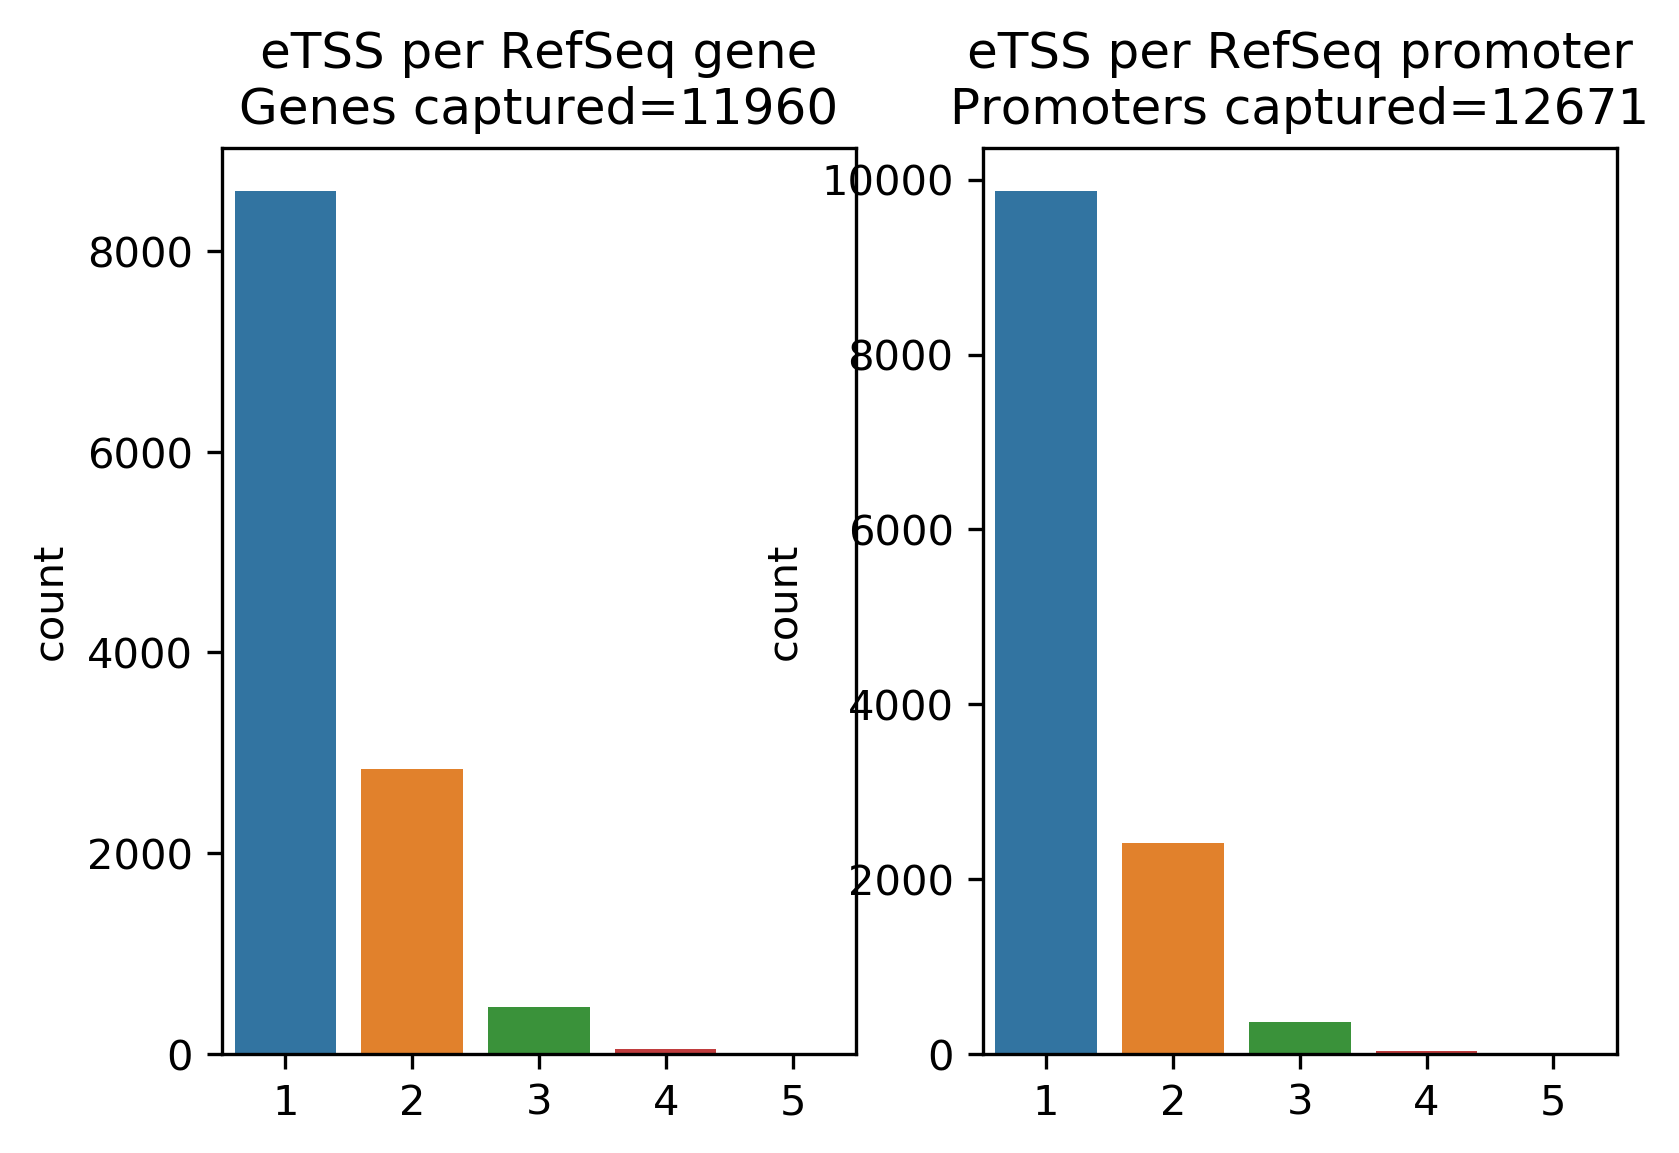

In [10]:
%matplotlib inline
df = pd.read_csv(allTSS_f, index_col=0)
pc = df[df['refType'] == 'mRNA']
print('num pc', len(pc))
refTSS = pd.read_csv(reftss_f, index_col=0, sep='\t')
pc = df[df['refType'] == 'mRNA']

## Get number of genes
pc['Gene'] = pc['Nearest TSS'].map(refTSS['gene'].to_dict())
genes_captured= set(pc['Gene'])
num_genes = len(genes_captured)

prom_captured= set(pc['Nearest TSS'])
num_prom=len(prom_captured)

f, ax= plt.subplots(nrows=1,ncols=2, dpi=300)
plt.rc('figure', titlesize=8) 
sns.countplot(pc.groupby('Gene').size(), ax=ax[0])
ax[0].title.set_text(f"eTSS per RefSeq gene\nGenes captured={num_genes}")
sns.countplot(pc.groupby('Nearest TSS').size(), ax=ax[1])
ax[1].title.set_text(f"eTSS per RefSeq promoter\nPromoters captured={num_prom}")

plt.subplots_adjust()
#helper_save('eTSS_per_refseq')

## Keeping introns

num pc 23641


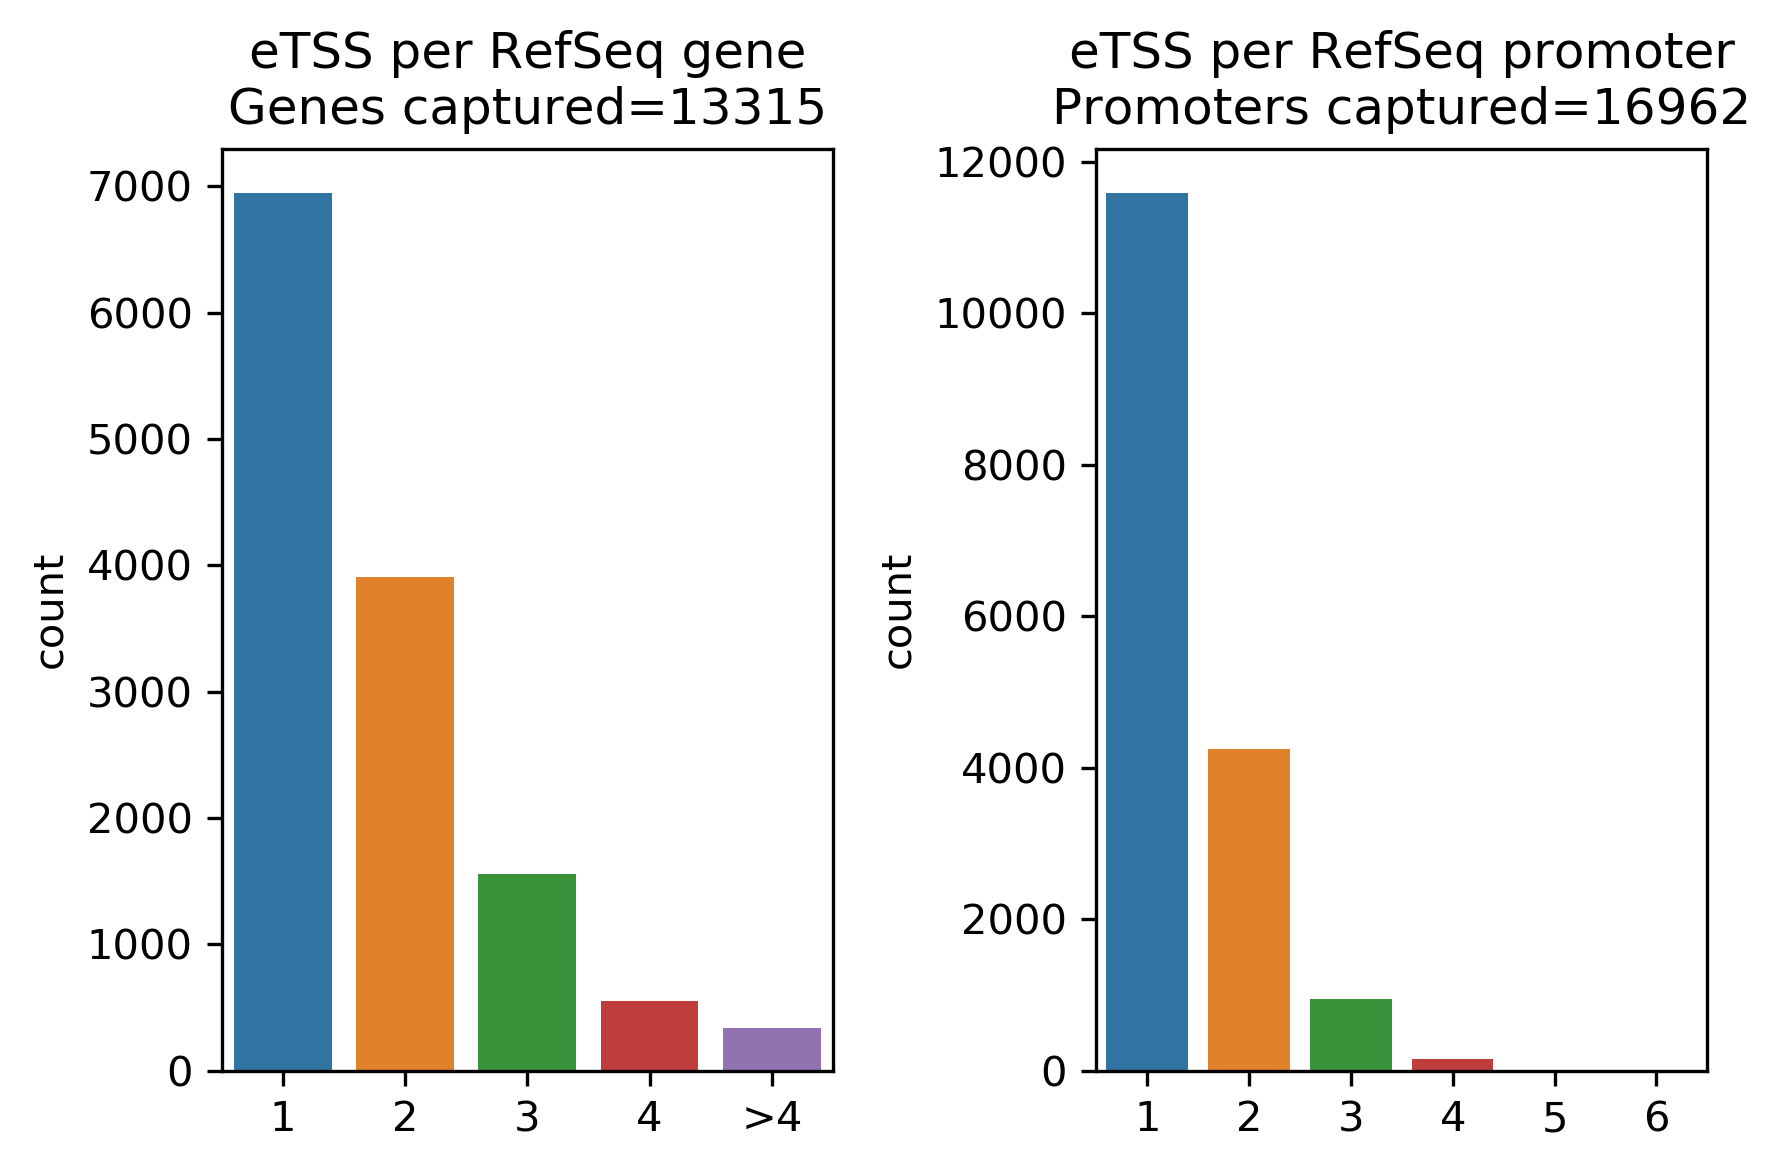

In [26]:
%matplotlib inline
df = pd.read_csv(allTSS_f.replace('.tsv', '.rmCDS.tsv'), index_col=0)
pc = df[df['refType'] == 'mRNA']
print('num pc', len(pc))
refTSS = pd.read_csv(reftss_f, index_col=0, sep='\t')
pc = (df.copy())[df['refType'] == 'mRNA']#df[df['refType'] == 'mRNA']

## Get number of genes
pc['Gene'] = pc['Nearest TSS'].map(refTSS['gene'].to_dict())
genes_captured= set(pc['Gene'])
num_genes = len(genes_captured)

prom_captured= set(pc['Nearest TSS'])
num_prom=len(prom_captured)

f, ax= plt.subplots(nrows=1,ncols=2, dpi=300)
plt.rc('figure', titlesize=8) 
sns.countplot(np.clip(pc.groupby('Gene').size(), a_min=1, a_max=5), ax=ax[0])
ax[0].title.set_text(f"eTSS per RefSeq gene\nGenes captured={num_genes}")
ticks = ax[0].get_xticklabels()
ticks[-1] = f">{int(ticks[-1].get_text())-1}"
ax[0].set_xticklabels(ticks)
sns.countplot(pc.groupby('Nearest TSS').size(), ax=ax[1])
ax[1].title.set_text(f"eTSS per RefSeq promoter\nPromoters captured={num_prom}")

f.tight_layout()
#helper_save('eTSS_per_refseq')

## ncRNA

In [13]:
pc

,ID,Distance to Nearest TSS,Nearest TSS,Distance to Nearest TSS_Rev,Nearest TSS_Rev,Annotation,homeranno,refType,isCDS,isIntron,isAbove_numsamples,isCHO,Gene


In [15]:
ncrna

['snoRNA', 'snRNA', 'miRNA', 'lnc_RNA']

num ncrna 2293


/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


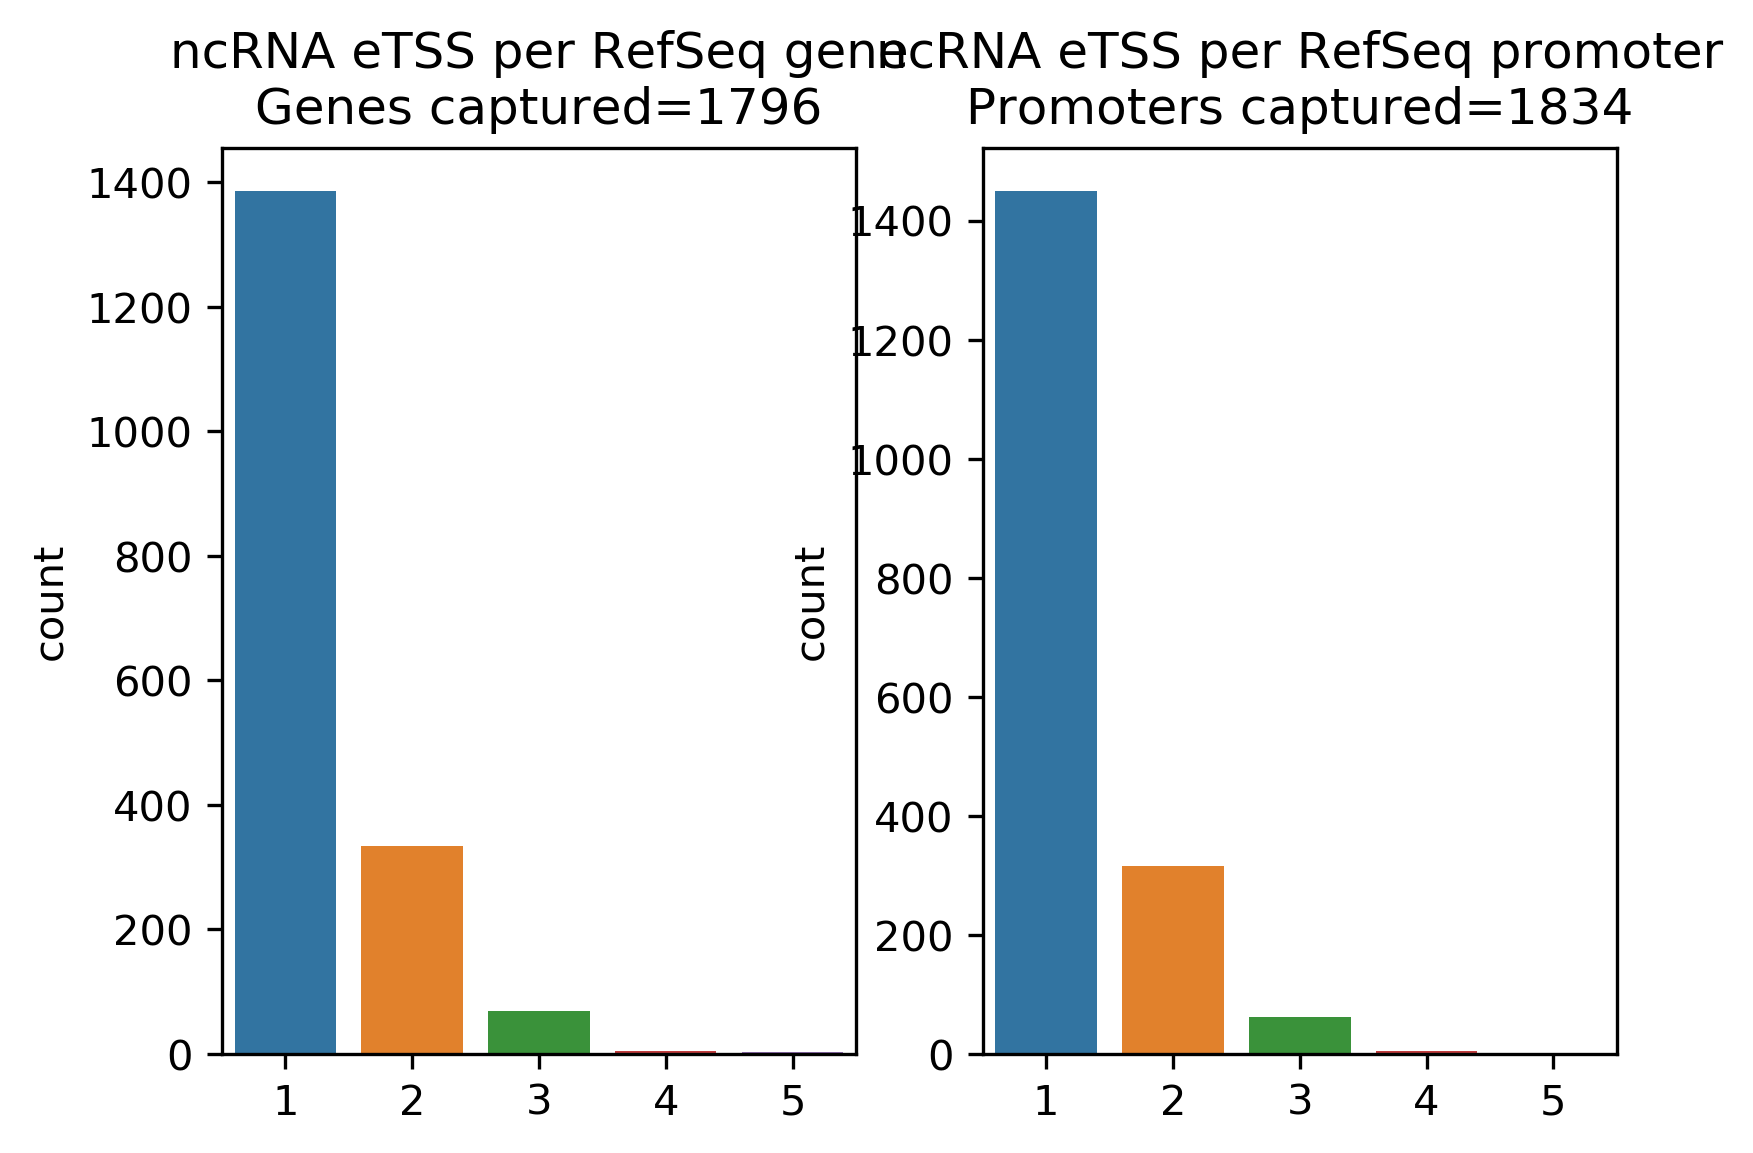

In [25]:
%matplotlib inline
df = pd.read_csv(allTSS_f, index_col=0)
ncrna = df[df['refType'] == "ncRNA"]
print('num ncrna', len(ncrna))
refTSS = pd.read_csv(reftss_f, index_col=0, sep='\t')
ncrna['Gene'] = ncrna['Nearest TSS'].map(refTSS['gene'].to_dict())
## Get number of genes
#ncrna['Gene'] = ncrna['Nearest TSS'].map(refTSS['gene'].to_dict())
genes_captured= set(ncrna['Gene'])
num_genes = len(genes_captured)

prom_captured= set(ncrna['Nearest TSS'])
num_prom=len(prom_captured)

f, ax= plt.subplots(nrows=1,ncols=2, dpi=300)
plt.rc('figure', titlesize=8) 
sns.countplot(ncrna.groupby('Gene').size(), ax=ax[0])
ax[0].title.set_text(f"ncRNA eTSS per RefSeq gene\nGenes captured={num_genes}")
sns.countplot(ncrna.groupby('Nearest TSS').size(), ax=ax[1])
ax[1].title.set_text(f"ncRNA eTSS per RefSeq promoter\nPromoters captured={num_prom}")

plt.subplots_adjust()
#helper_save('eTSS_per_refseq')